In [2]:
import datasets

In [3]:
from datasets import load_dataset

In [4]:
import io

In [5]:
import matplotlib.pyplot as plt

In [6]:
import numpy as np

In [7]:
from PIL import Image

In [8]:
import cv2

In [9]:
dataset = load_dataset("nateraw/pascal-voc-2012", split = "train")

Using custom data configuration nateraw___pascal-voc-2012-c68607404d4811ac
Reusing dataset parquet (/aiffel/.cache/huggingface/datasets/parquet/nateraw___pascal-voc-2012-c68607404d4811ac/0.0.0/9296ce43568b20d72ff8ff8ecbc821a16b68e9b8b7058805ef11f06e035f911a)


In [10]:
image = []
mask = []

In [11]:
for idx, data in enumerate(dataset):
    image.append(cv2.imdecode(np.frombuffer(data["image"]["bytes"], np.uint8), -1))
    #image.append( (data["image"]["bytes"]))
    mask.append(cv2.imdecode(np.frombuffer(data["mask"]["bytes"], np.uint8), -1))
    #mask.append( (data["mask"]["bytes"]))    

In [12]:
print(len(image))

2913


In [13]:
print(len(mask))

2913


In [14]:
print(image[20].shape)

(375, 500, 3)


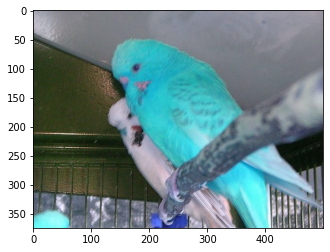

In [15]:
plt.imshow(image[20])
plt.show()

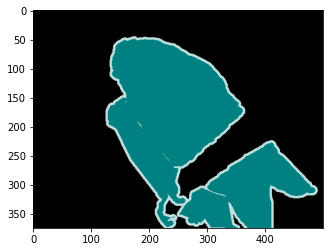

In [16]:
plt.imshow(mask[20])
plt.show()

In [17]:
for idx, img in enumerate(image):
    if image[idx].shape != mask[idx].shape:
        print("불일치 타입 발견")

In [18]:
# 타입 (375, 500, 3) 아닌것 갯수 체크
cnt = 0
for idx, img in enumerate(image):
    if img.shape != (572, 572, 3):
        cnt += 1
        print(str(idx))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
cnt

2913

In [20]:
# 타입 (375, 500, 3) 아닌것 resize
for idx, img in enumerate(image):
    if img.shape != (572, 572, 3):
        image[idx] = cv2.resize(image[idx],(572, 572))
        mask[idx] = cv2.resize(mask[idx],(572, 572))        

In [21]:
image[7].shape

(572, 572, 3)

In [22]:
mask[7].shape

(572, 572, 3)

In [23]:
# 타입 (375, 500, 3) 아닌것 재확인
cnt = 0
for idx, img in enumerate(image):
    if img.shape != (572, 572, 3):
        cnt += 1
        print(str(idx))

In [24]:
cnt

0

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
import tensorflow as tf

In [27]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow import keras

In [28]:
x_train, x_test, y_train, y_test = train_test_split(image, mask, train_size=0.6, random_state=1, shuffle=False)

In [29]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1, shuffle=False)

In [104]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(ConvBlock, self).__init__()

        self.conv1 = Conv2D(n_filters, 3)
        self.conv2 = Conv2D(n_filters, 3)

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

        self.activation = Activation('relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        
        return x

In [129]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(EncoderBlock, self).__init__()

        self.conv_blk = ConvBlock(n_filters)
        self.pool = MaxPooling2D((2,2))

    def call(self, inputs):
        x = self.conv_blk(inputs)
        p = self.pool(x)
        
        print(x.shape)
        print(p.shape)
        
        return x, p

In [146]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(DecoderBlock, self).__init__()

        self.up = Conv2DTranspose(n_filters, (2,2), strides=2, padding='same')
        self.conv_blk = ConvBlock(n_filters)

    def call(self, inputs, skip):
        x = self.up(inputs)
        
        
        print(type(x))
        
        
        x = Concatenate()([x, skip])
        x = self.conv_blk(x)

        print(x.shape)
        
        
        return x

In [147]:
class UNET(tf.keras.Model):
    def __init__(self, n_classes):
        super(UNET, self).__init__()

        # Encoder
        self.e1 = EncoderBlock(64)
        self.e2 = EncoderBlock(128)
        self.e3 = EncoderBlock(256)
        self.e4 = EncoderBlock(512)

        # Bridge
        self.b = ConvBlock(1024)

        # Decoder
        self.d1 = DecoderBlock(512)
        self.d2 = DecoderBlock(256)
        self.d3 = DecoderBlock(128)
        self.d4 = DecoderBlock(64)

        # Outputs
        if n_classes == 1:
            activation = 'sigmoid'
        else:
            activation = 'softmax'

        self.outputs = Conv2D(n_classes, 1, padding='same', activation=activation)

    def call(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)
        print(b.shape)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


In [148]:
model = UNET(1)

In [149]:
outputs = model(keras.Input(shape = (572, 572, 3)))

(None, 568, 568, 64)
(None, 284, 284, 64)
(None, 280, 280, 128)
(None, 140, 140, 128)
(None, 136, 136, 256)
(None, 68, 68, 256)
(None, 64, 64, 512)
(None, 32, 32, 512)
(None, 28, 28, 1024)
<class 'tensorflow.python.framework.ops.Tensor'>


ValueError: in user code:

    /tmp/ipykernel_95/1498869556.py:37 call  *
        d1 = self.d1(b, s4)
    /tmp/ipykernel_95/3896178493.py:15 call  *
        x = Concatenate()([x, skip])
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1030 __call__  **
        self._maybe_build(inputs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:2659 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /opt/conda/lib/python3.9/site-packages/keras/utils/tf_utils.py:259 wrapper
        output_shape = fn(instance, input_shape)
    /opt/conda/lib/python3.9/site-packages/keras/layers/merge.py:515 build
        raise ValueError(err_msg)

    ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 56, 56, 512), (None, 64, 64, 512)]


In [ ]:
model.compile()

In [ ]:
model.fit()

In [ ]:
model.predict()

In [ ]:
model.evaluate()